In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline

In [2]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Utils.DataReader import load_urm, load_target

In [3]:
URM_all = load_urm()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.85)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1607 ( 3.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 903 ( 2.2%) Users that have less than 1 test interactions


## Item Based Collaborative Filtering

In [4]:
item_id = 100
shrink = 10

numerator_vector = URM_train.T[item_id].dot(URM_train).toarray().ravel()
numerator_vector

array([2., 6., 1., ..., 2., 1., 0.])

In [5]:
item_norms = np.sqrt(np.array(URM_train.power(2).sum(axis=0))).ravel()
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector
similarity_vector

array([0.01659829, 0.0366872 , 0.0075126 , ..., 0.01922585, 0.01030379,
       0.        ])

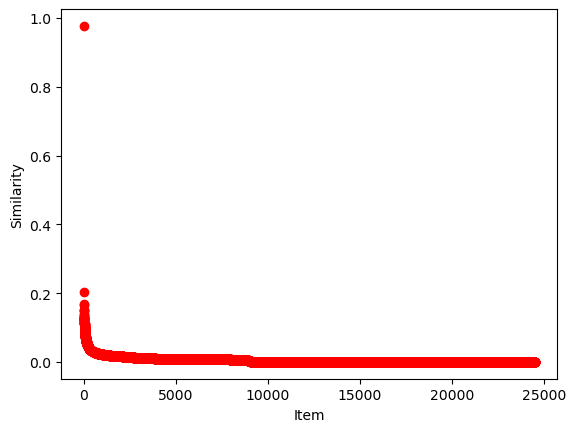

In [6]:
sorted_item_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [7]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100,
                                              topK=50, normalize=True,
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 24507 (100.0%), 447.71 column/sec. Elapsed time 54.74 sec


In [8]:
user_id = 100

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

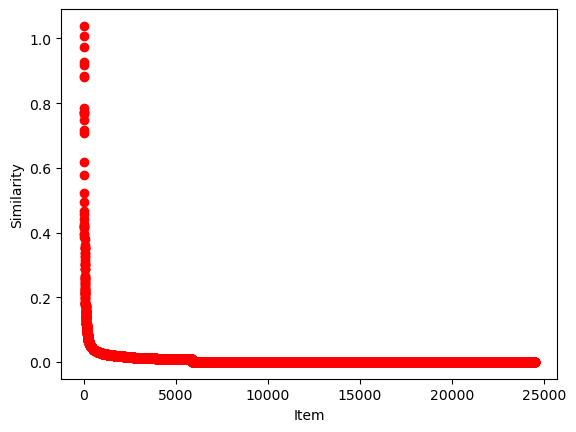

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [10]:
ranking[0:10]

array([ 555,  826,  153,  541,  775, 1108,  626,  993,  385,  537],
      dtype=int64)

## Let's create the Recommender

In [11]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink,
                                                      topK=topK, normalize=normalize,
                                                      similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Testing the Recommender

In [12]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=50.0, topK=100)

Similarity column 24507 (100.0%), 417.89 column/sec. Elapsed time 58.64 sec


## Evaluation - Hyperparameter Tuning

### Number of neighbors

In [13]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

Similarity column 24507 (100.0%), 3059.89 column/sec. Elapsed time 8.01 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 43.00 sec. Users per second: 931
Similarity column 24507 (100.0%), 2642.20 column/sec. Elapsed time 9.28 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 49.35 sec. Users per second: 811
Similarity column 24507 (100.0%), 2650.29 column/sec. Elapsed time 9.25 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 43.50 sec. Users per second: 920
Similarity column 24507 (100.0%), 2931.95 column/sec. Elapsed time 8.36 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 48.67 sec. Users per second: 822
Similarity column 24507 (100.0%), 2526.68 column/sec. Elapsed time 9.70 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 1.10 min. Users per second: 607


In [14]:
result_df

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.037095,0.070824,0.067896,0.01669,0.031523,0.124101,0.063238,0.047977,0.274174,0.143332,...,0.961397,0.26359,0.961397,0.040059,8.89469,0.991787,0.079158,0.65929,4.20976,0.294022


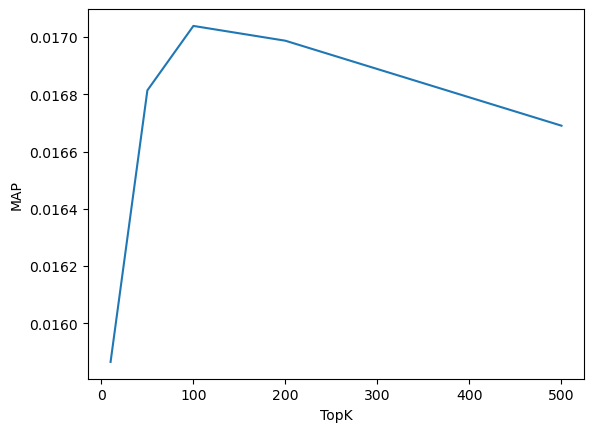

In [15]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

### Shrinkage

In [16]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

Similarity column 24507 (100.0%), 2852.72 column/sec. Elapsed time 8.59 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 45.10 sec. Users per second: 887
Similarity column 24507 (100.0%), 2761.68 column/sec. Elapsed time 8.87 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 43.29 sec. Users per second: 925
Similarity column 24507 (100.0%), 2787.38 column/sec. Elapsed time 8.79 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 53.58 sec. Users per second: 747
Similarity column 24507 (100.0%), 2974.85 column/sec. Elapsed time 8.24 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 1.03 min. Users per second: 645
Similarity column 24507 (100.0%), 3081.13 column/sec. Elapsed time 7.95 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 1.02 min. Users per second: 651
Similarity column 24507 (100.0%), 2536.93 column/sec. Elapsed time 9.66 sec
EvaluatorHoldout: Processed 40022 (100.0%) in 1.13 min. Users per second: 590


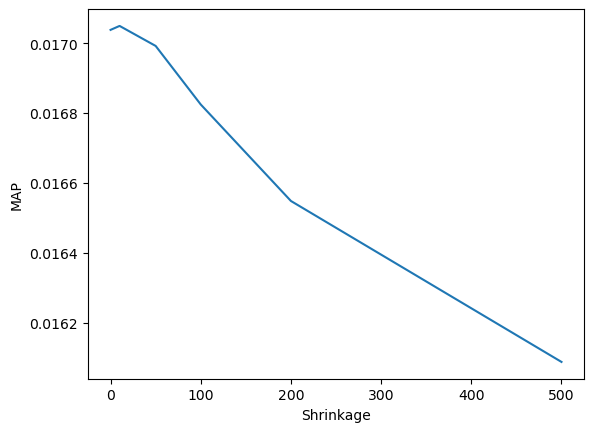

In [17]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## Submissions

In [18]:
test_users = pd.read_csv('Dataset/data_target_users_test.csv')

In [19]:
user_id = test_users['user_id']
recommendations = []
for user in user_id:
    recommendations.append(recommender.recommend(user, cutoff=10))

In [20]:
for index in range(len(recommendations)):
    recommendations[index]=np.array(recommendations[index])

test_users['item_list']= recommendations
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])
test_users.to_csv('Submissions\Submission_ItemKNN_URM_views_clicks.csv', index=False)